# Limpieza del conjunto de datos *Vialidades-OSM*

En esta *notebook* se documenta el proceso de **limpieza** del conjunto de datos **Vialidades-OSM**, correspondiente a la red vial del municipio de Hermosillo, Sonora, obtenida desde **OpenStreetMap** (OSM) mediante la librería [OSMnx](https://osmnx.readthedocs.io/en/stable/).  

El proposito es identificar patrones, inconsisetencias y posibles estrategias de limpieza de la información geoespacial relacionada con las vialidades, con el fin de obtener un conjunto de datos *tidy* listo para su posterior análisis e integración con otras fuentes (atus, colonias, clima). 

Los datos provienen de OpenStreetMap y fueron descargados directamente a través del *script*: 

```bash
python src/extract_vialidades.py
```

Este script genera los archivos de *nodes* y *edges* correspondientes a la red vial de Hermosillo, almacenándolos en la carpeta [`data/raw/vialidades`](../data/raw/vialidades/). 


## 0. Configuración del entorno

Importamos las librerías principales: 

In [1]:
from pathlib import Path

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import missingno as msno

Definimos una ruta a un directorio temporal para almacenar datos en caso de ser necesario:

In [152]:
temp_dir = Path().resolve().parent / "data" / "temp" / "vialidades"
temp_dir.mkdir(parents=True, exist_ok=True)

Definimos las rutas de acceso a los datos *raw* del conjunto Vialidades-OSM: 

In [2]:
root = Path().resolve().parent
data_dir = root / "data"
raw_dir = data_dir / "raw"
vialidades_dir = raw_dir / "vialidades"

for item in vialidades_dir.iterdir(): 
    print(item.relative_to(root))

data\raw\vialidades\cache_osmnx
data\raw\vialidades\edges
data\raw\vialidades\nodes


En el directorio `data/raw/vialidades` se encuentran tres subdirectorios: `cache_osmnx`, `edges`, `nodes`. 

En este proyecto nos interesa **analizar las vialidades y sus características**, es por ello que solo consideramos los datos en el subdirectorio `edges` que contiene el conjunto de datos de las vialidades en sí. 

Deifinimos el directorio de los *edges* y verificamos su contenido: 

In [4]:
edges_dir = vialidades_dir / "edges"

for item in edges_dir.iterdir(): 
    print(item.relative_to(root))

data\raw\vialidades\edges\hermosillo_edges.cpg
data\raw\vialidades\edges\hermosillo_edges.dbf
data\raw\vialidades\edges\hermosillo_edges.geojson
data\raw\vialidades\edges\hermosillo_edges.prj
data\raw\vialidades\edges\hermosillo_edges.shp
data\raw\vialidades\edges\hermosillo_edges.shx


El scrip de extracción de los datos genera el conjunto de datos en formatos `shapefile` y `GeoJson`. Aquí consideraremos el formato GeoJSON debido a su fácil visualización mediante un explorador de archivos. 

Definimos el path al archivo GeoJSON: 

In [6]:
vialidades_geojson = edges_dir / "hermosillo_edges.geojson"

# Verificamos que el archivo existe y puede cargarse en memoria: 

vialidades_geojson.exists(), vialidades_geojson.is_file()

(True, True)

A continuación una breve explicación de los *nodes* y *edges* generados al extraer información usando OSMnx. 

---

### 0.1 Nodos (*nodes*) y aristas (*edges*) en OSMnx

Cuando se descarga una red vial con OSMnx, el resultado es un **gráfo** donde: 

* Los *nodes* reprecentan **puntos geográficos** dentro de la red vial, como intersecciones, esquinas o puntos donde **cambia la geometría** de una calle. 

    Cada nodo tiene coordenadas (latitud, longitud) y atributos como el identificador `osmid`. 

* Los *edges* reprecentas los **tramos de la vialidad** que conectan dos nodos. 

    Cada *edge* contiene información sobre la calle o camino que une esos puntos: nombre, tipo de vialidad, número de carriles, longitud, si es de un solo sentido, velocidad máxima, entre otros. 

#### 0.1.1 ¿Por qué solo consideraremos los *edges*?

En este proyecto nos interesa **análizar las características de las redes viales**, más que la estructura de la red o la ubicación presisa de los cruces. Por ello, **solo se utilizan los edges**, ya que contienen información relevantes de las calles en sí. 


---

### 0.2 Algunas funciones auxiliares


A continuación se definen algunas funciones auxiliares útiles para explorar el conjunto de datos: 

In [7]:
def add_basemap_to_ax(ax, crs):
    ctx.add_basemap(
        ax, 
        source=ctx.providers.OpenStreetMap.Mapnik, 
        crs=crs.to_string()
    )

## 1. Carga y descripción general 

Cargamos los datos de las vialidades usando *GeoPandas*: 

In [8]:
vialidades = gpd.read_file(vialidades_geojson)

Los primeros registros: 

In [9]:
vialidades.head()

u           v  key      osmid    highway         name  \
0  316362546  6537750285    0  566790774   tertiary     Calle 26   
1  316362546  3173455691    0  566790774   tertiary     Calle 26   
2  316362546  6542756945    0  566802152  secondary  Calle 4 Sur   
3  316362546  8672499462    0  566802152  secondary  Calle 4 Sur   
4  316362548  6539996172    0  566802152  secondary  Calle 4 Sur   

              ref  oneway  reversed      length maxspeed lanes bridge width  \
0  SON 110;SON 26   False     False  260.625403     None  None   None  None   
1  SON 110;SON 26   False      True   78.609461     None  None   None  None   
2          SON 61   False     False  629.709375     None  None   None  None   
3          SON 61   False      True   28.811070     None  None   None  None   
4          SON 61   False     False   44.296838     None  None   None  None   

  tunnel junction access                                           geometry  
0   None     None   None  LINESTRING (-111.39132 28.56881, -111.39399 28...  
1   None     None   None  LINESTRING (-111.39132 28.56881, -111.39051 28...  
2   None     None   None  LINESTRING (-111.39132 28.56881, -111.39131 28...  
3   None     None   None  LINESTRING (-111.39132 28.56881, -111.39132 28...  
4   None     None   None  LINESTRING (-111.39091 28.4463, -111.39076 28....

Información general: 

In [10]:
vialidades.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 286878 entries, 0 to 286877
Data columns (total 18 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   u         286878 non-null  int64   
 1   v         286878 non-null  int64   
 2   key       286878 non-null  int32   
 3   osmid     286878 non-null  int32   
 4   highway   286878 non-null  object  
 5   name      106608 non-null  object  
 6   ref       12798 non-null   object  
 7   oneway    286878 non-null  bool    
 8   reversed  286878 non-null  bool    
 9   length    286878 non-null  float64 
 10  maxspeed  11503 non-null   object  
 11  lanes     10895 non-null   object  
 12  bridge    519 non-null     object  
 13  width     722 non-null     object  
 14  tunnel    16 non-null      object  
 15  junction  877 non-null     object  
 16  access    118 non-null     object  
 17  geometry  286878 non-null  geometry
dtypes: bool(2), float64(1), geometry(1), int32(2), int64(2),

Visualizamos los valores nulos: 

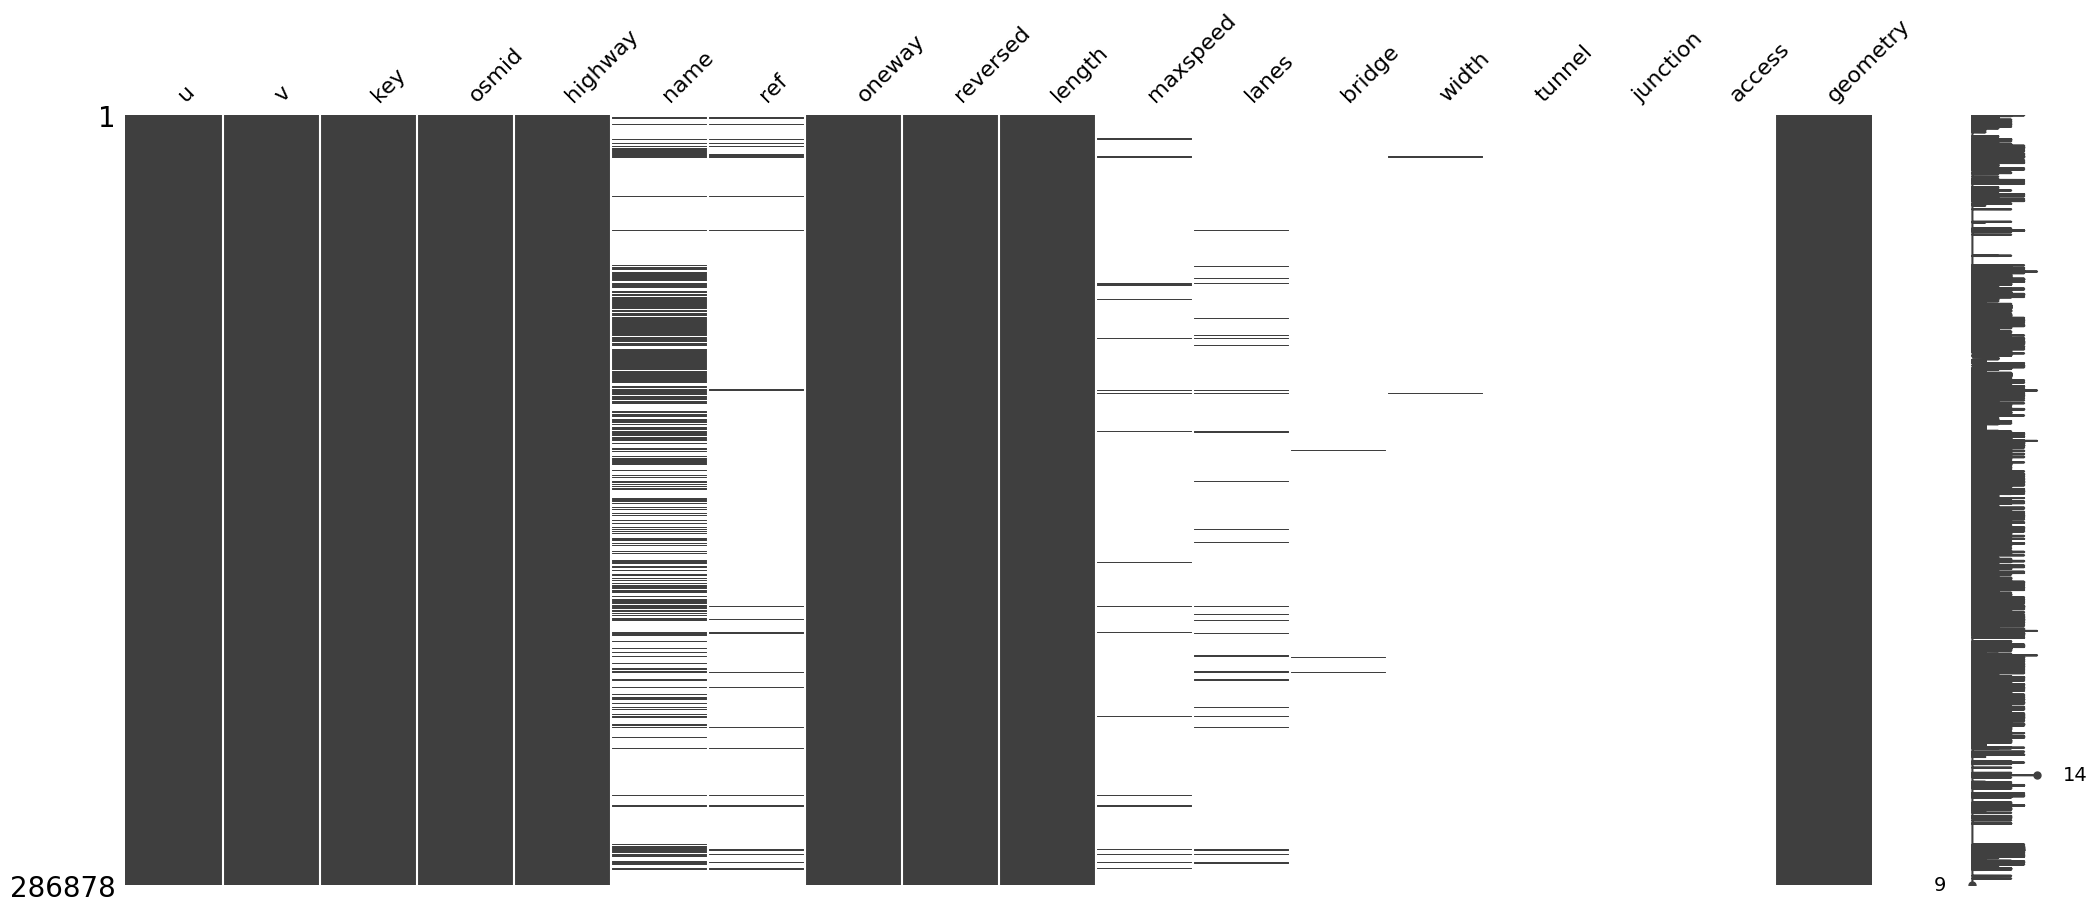

In [11]:
msno.matrix(vialidades)
plt.show()

El porcentage de registros nulos por columna: 

In [13]:
100*vialidades.isnull().mean()

u            0.000000
v            0.000000
key          0.000000
osmid        0.000000
highway      0.000000
name        62.838559
ref         95.538870
oneway       0.000000
reversed     0.000000
length       0.000000
maxspeed    95.990282
lanes       96.202218
bridge      99.819087
width       99.748325
tunnel      99.994423
junction    99.694295
access      99.958868
geometry     0.000000
dtype: float64

Las columnas `access`, `bridge`, `width`, `tunnel`, `junction`, `ref` están prácticamente vacías.

Los tipos de geometría únicos: 

In [15]:
vialidades.geom_type.unique()

array(['LineString'], dtype=object)

EL *crs* (*coordinate reference system*): 

In [16]:
vialidades.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

El *crs* utilizado corresponde `epgs=4326` cuyas unidades son grados decimales. 

Verifiquemos la proyección de la red vial sobre el mapa de Hermosillo: 

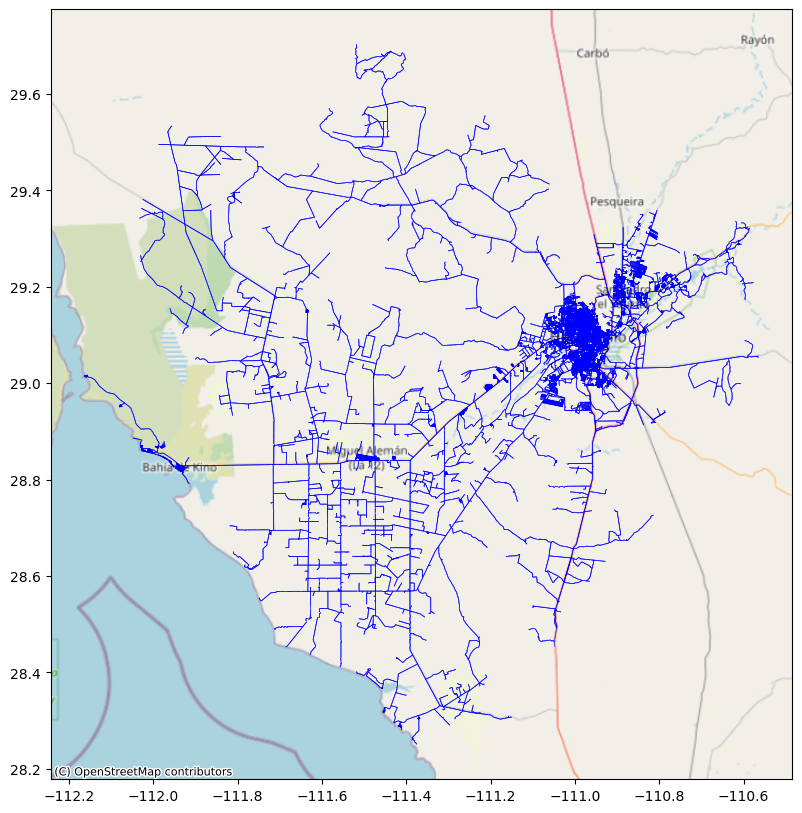

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

vialidades.plot(
    ax=ax, 
    linewidth=0.5, 
    color='blue', 
)
add_basemap_to_ax(ax, vialidades.crs)
plt.show()

Observamos que el dataset contiene **todo** el conjunto de vialidades en el **municipio de Hermosillo**, por lo que hay que filtrar los datos para obtener los correspondientes a la zona urbana de Hermosillo. 

## 2. Exploración y limpieza del conjunto de datos

Iniciamos por filtrar los datos que corresponden a la **zona urbana de Hermosillo**. 

Para ello definimos una *boundry box* de la zona urbana con las siguientes coordenadas límite: 

In [18]:
# Coordenadas límite (x = longitudes, y = latitudes)
x_min, x_max = -111.075, -110.900
y_min, y_max = 28.900, 29.200

In [19]:
from shapely.geometry import box

In [22]:
%pdoc box

Class docstring:
    Return a rectangular polygon with configurable normal vector.
Call docstring:
    Call self as a function.

El rectángulo que reprecenta el área urbana de Hermosillo: 

In [20]:
bbox = box(x_min, y_min, x_max, y_max)

Ahora, intersecamos el *boundry box* con las vialidades de Hermosillo: 

In [21]:
vialidades_urb = vialidades[vialidades.intersects(bbox)]

Visualizamos el resultado: 

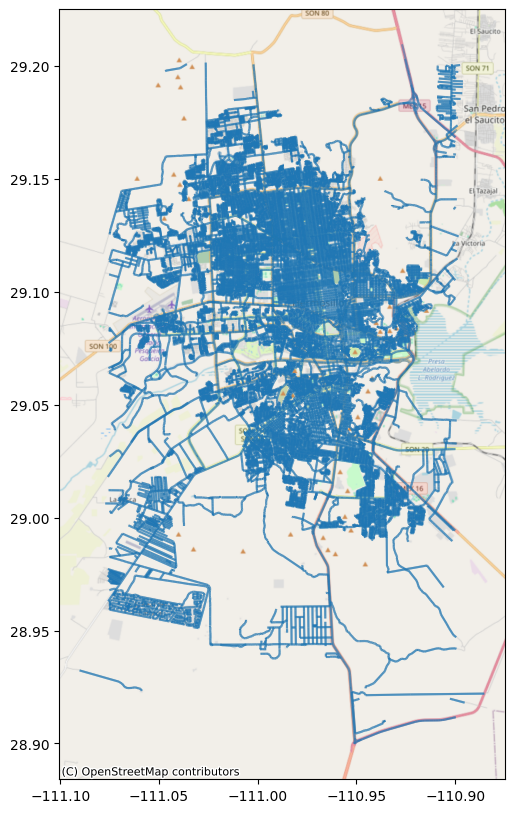

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

vialidades_urb.plot(
    ax=ax, 
    alpha=0.5,  
)
add_basemap_to_ax(ax, vialidades_urb.crs)
plt.show()

Observamos que las vialidades corresponden a la zona urbana de Hermosillo. 

Guardamos los datos filtrados de la zona urbana en el directorio temporal: 

In [ ]:
vialidades_urb.to_file(temp_dir.joinpath("vialidades_urb.geojson"), driver='GeoJSON')

El total de registros:

In [24]:
len(vialidades_urb)

146763

Las columnas: 

In [28]:
columns = vialidades_urb.columns
columns.to_list()

['u',
 'v',
 'key',
 'osmid',
 'highway',
 'name',
 'ref',
 'oneway',
 'reversed',
 'length',
 'maxspeed',
 'lanes',
 'bridge',
 'width',
 'tunnel',
 'junction',
 'access',
 'geometry']

In [29]:
len(columns)

18

Tenemos 18 columnas.

En Hermosillo no hay una gran cantidad de tuneles y puentes, por lo que podemos elimnar estas columnas: 

In [133]:
vialidades_urb.drop(columns=['tunnel', 'bridge'], inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\779575340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.drop(columns=['tunnel', 'bridge'], inplace=True)


Las columnas `u`, `v` se usan para identificar el nodo de origen y destino respectivamente. 

In [30]:
len(vialidades_urb['u']), len(vialidades_urb['u'].unique())

(146763, 73017)

In [31]:
len(vialidades_urb['v']), len(vialidades_urb['v'].unique())

(146763, 73016)

La columna `key` asocia un nodo  cuando existen varios *edges* entre los mismos nodos `u`, `v`: 

In [32]:
len(vialidades_urb['key'])

146763

La columna `osmid` identifica cada registro con la base de datos de *OpenStreetMap*: 

In [33]:
len(vialidades_urb['osmid'])

146763

In [34]:
len(vialidades_urb['osmid'].unique())

14815

Las columnas {`u`, `v`, `key`, `osmid`} no serán de utilidad. Podemos eliminarlas: 

In [36]:
vialidades_urb.drop(columns=['u', 'v', 'key', 'osmid',], inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\3986037824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.drop(columns=['u', 'v', 'key', 'osmid',], inplace=True)


La columna `highway` reprecenta el tipo de vía según OSM. 


In [43]:
vialidades_urb['highway'].info()

<class 'pandas.core.series.Series'>
Index: 146763 entries, 55964 to 249876
Series name: highway
Non-Null Count   Dtype 
--------------   ----- 
146763 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB


In [44]:
vialidades_urb['highway'].describe()

count          146763
unique             13
top       residential
freq           111597
Name: highway, dtype: object

Los valores únicos: 

In [42]:
vialidades_urb['highway'].unique()

array(['residential', 'primary', 'secondary', 'trunk_link', 'trunk',
       'tertiary', 'motorway', 'primary_link', 'secondary_link',
       'unclassified', 'motorway_link', 'tertiary_link', 'living_street'],
      dtype=object)

In [41]:
vialidades_urb['highway'].value_counts()

highway
residential       111597
unclassified       14379
tertiary            8575
primary             4945
secondary           3259
primary_link        1453
trunk                966
trunk_link           509
secondary_link       413
tertiary_link        238
motorway_link        208
motorway             195
living_street         26
Name: count, dtype: int64

Conviene renombrar esta columna. 

Consideremos el nombre `tipo_vialidad`: 

In [48]:
vialidades_urb.rename(columns={'highway': 'tipo_vialidad'}, inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\3086850428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.rename(columns={'highway': 'tipo_vialidad'}, inplace=True)


In [ ]:
vialidades_urb.head();  # OK

De igual forma, es conveniente renombrar los tipos de vialidades a nombres reconocibles en español.

Para ello definomos la variable `tipo_vialidades_map` que posee nombres reconocibles para cada tipo de vialidad basandonos en la Wiki de OSM en español: 

In [ ]:
tipo_vialidades_map = {
    'motorway': 'Autopista',
    'motorway_link': 'Conector autopista',
    'trunk': 'Carretera principal',
    'trunk_link': 'Conector carretera',
    'primary': 'Vía primaria',
    'primary_link': 'Conector primaria',
    'secondary': 'Vía secundaria',
    'secondary_link': 'Conector secundaria',
    'tertiary': 'Vía terciaria',
    'tertiary_link': 'Conector terciaria',
    'residential': 'Calle residencial',
    'unclassified': 'Calle menor',
    'living_street': 'Calle peatonal'
}

In [54]:
vialidades_urb['tipo_vialidad'] = vialidades_urb['tipo_vialidad'].replace(tipo_vialidades_map)

c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Verificamos los cambios: 

In [55]:
vialidades_urb['tipo_vialidad'].unique()

array(['Calle residencial', 'Vía primaria', 'Vía secundaria',
       'Conector carretera', 'Carretera principal', 'Vía terciaria',
       'Autopista', 'Conector primaria', 'Conector secundaria',
       'Calle menor', 'Conector autopista', 'Conector terciaria',
       'Calle peatonal'], dtype=object)

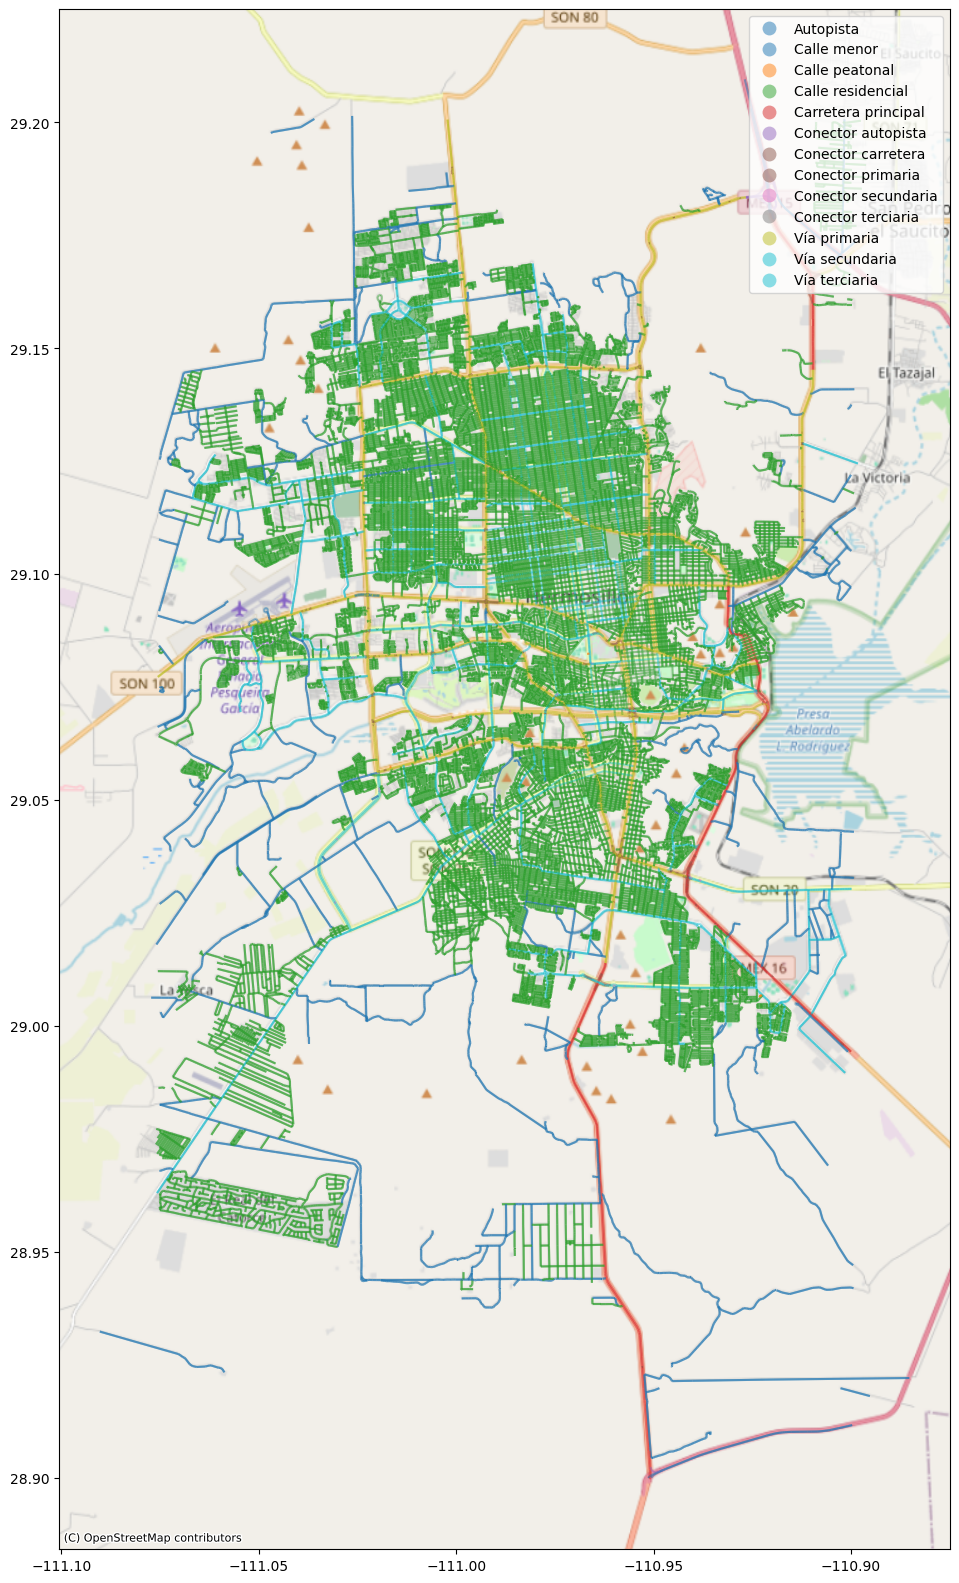

In [56]:
fig, ax = plt.subplots(1, figsize=(20, 20))
vialidades_urb.plot(
    'tipo_vialidad', 
    ax=ax,
    alpha=0.5,
    legend=True, 
)
add_basemap_to_ax(ax, vialidades_urb.crs)
plt.show()

La columna 'name' almacena el nombre de la vialidad: 

In [58]:
vialidades_urb['name'].info()

<class 'pandas.core.series.Series'>
Index: 146763 entries, 55964 to 249876
Series name: name
Non-Null Count  Dtype 
--------------  ----- 
87788 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB


In [61]:
vialidades_urb['name'].isnull().value_counts(normalize=True)

name
False    0.598162
True     0.401838
Name: proportion, dtype: float64

La columna posee casí el 50% de valores nulos. 

In [64]:
vialidades_urb[vialidades_urb['name'].isnull()]['tipo_vialidad'].value_counts(normalize=True)

tipo_vialidad
Calle residencial      0.709877
Calle menor            0.216889
Conector primaria      0.021721
Vía terciaria          0.020500
Conector carretera     0.008207
Conector secundaria    0.006884
Vía secundaria         0.006579
Conector terciaria     0.003781
Conector autopista     0.003527
Carretera principal    0.000950
Vía primaria           0.000543
Autopista              0.000288
Calle peatonal         0.000254
Name: proportion, dtype: float64

Las calles de tipo residencial son las que poseen mayor cantidad de valores nulos. 

In [59]:
vialidades_urb['name'].describe()

count                     87788
unique                     4746
top       Boulevard Solidaridad
freq                        912
Name: name, dtype: object

El total de nombres únicos

In [ ]:
len(vialidades_urb['name'].unique())

4747

EL top 10 vialidades con más registros: 

In [65]:
vialidades_urb['name'].value_counts()[:10]

name
Boulevard Solidaridad                 912
Boulevard Doctor Antonio Quiroga      425
Camino del Seri                       391
Carretera a Costa de Hermosillo       362
Boulevard José María Morelos Norte    320
Calle General Miguel Piña             307
Boulevard Francisco Serna             300
Boulevard Enrique Mazón López         298
Calle General Bernardo Reyes          297
Carlos Quintero Arce                  296
Name: count, dtype: int64

In [68]:
top10 = vialidades_urb['name'].value_counts()[:10].index.tolist()
top10

['Boulevard Solidaridad',
 'Boulevard Doctor Antonio Quiroga',
 'Camino del Seri',
 'Carretera a Costa de Hermosillo',
 'Boulevard José María Morelos Norte',
 'Calle General Miguel Piña',
 'Boulevard Francisco Serna',
 'Boulevard Enrique Mazón López',
 'Calle General Bernardo Reyes',
 'Carlos Quintero Arce']

Con lo anterior, la columna `name` la renombraremos a `nombre` y normalizaremos su contenido: 

In [73]:
vialidades_urb.rename(columns={'name': 'nombre'}, inplace=True)

vialidades_urb['nombre'] = vialidades_urb['nombre'].str.lower()

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\1633296208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.rename(columns={'name': 'nombre'}, inplace=True)
c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Verificamos el contenido: 

In [76]:
vialidades_urb.head();  # OK

La columna 'ref' reprecenta el código de referencia: 

In [79]:
vialidades_urb['ref'].info()

<class 'pandas.core.series.Series'>
Index: 146763 entries, 55964 to 249876
Series name: ref
Non-Null Count  Dtype 
--------------  ----- 
2802 non-null   object
dtypes: object(1)
memory usage: 6.3+ MB


In [80]:
vialidades_urb['ref'].isnull().value_counts(normalize=True)

ref
True     0.980908
False    0.019092
Name: proportion, dtype: float64

Más del 95% de las vialidades no poseen código de referencia.

In [81]:
vialidades_urb['ref'].unique()

array([None, 'MEX 15', 'MEX 15D', 'SON 100', 'MEX 14', 'MEX 16',
       'MEX 16;MEX 15D', 'SON 20', 'SON 110;SON 26', 'SON 82'],
      dtype=object)

`ref` no es una columna útil para el proposito del proyecto, podemos eliminarla: 

In [83]:
vialidades_urb.drop(columns='ref', inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\1551629736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.drop(columns='ref', inplace=True)


La columna `oneway` indica si la vía es de un solo sentido (`True`/`False`): 


In [77]:
vialidades_urb['oneway'].value_counts(normalize=True)

oneway
False    0.815028
True     0.184972
Name: proportion, dtype: float64

Renombraremos la columna `oneway` a `un_sentido`: 

In [84]:
vialidades_urb.rename(columns={'oneway': 'un_sentido'}, inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\1156103807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.rename(columns={'oneway': 'un_sentido'}, inplace=True)


La columna `reversed` indica si el tramo fue invertido en la extracción (dirección opuesta a la original):

In [85]:
vialidades_urb['reversed'].value_counts(normalize=True)

reversed
False    0.592486
True     0.407514
Name: proportion, dtype: float64

Esta columa no es de utilidad, ya que almacena información proporcionada por OSMnx del grafo de la red vial. Podemos eliminarla: 

In [87]:
vialidades_urb.drop(columns='reversed', inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\4060830126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.drop(columns='reversed', inplace=True)


La columna 'lenght' reprecenta la longitud del tramo (en metros, calculada por OSMnx): 

In [88]:
vialidades_urb.sort_values(by='length', ascending=False).head(3)

tipo_vialidad nombre  un_sentido       length maxspeed lanes bridge  \
248598   Calle menor   None       False  3631.432679     None  None   None   
249639   Calle menor   None       False  3631.432679     None  None   None   
248762   Calle menor   None       False  2014.353677     None  None   None   

       width tunnel junction access  \
248598  None   None     None   None   
249639  None   None     None   None   
248762  None   None     None   None   

                                                 geometry  
248598  LINESTRING (-110.92254 28.92169, -110.88523 28...  
249639  LINESTRING (-110.88523 28.92206, -110.92254 28...  
248762  LINESTRING (-111.09022 28.93234, -111.07032 28...

Renombremos la columa `length` a `longitud_m` (longitud en metros): 

In [90]:
vialidades_urb.rename(columns={'length': 'longitud'}, inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\3051258691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.rename(columns={'length': 'longitud'}, inplace=True)


La columna `maxspeed` reprecenta el límite de velocidad máxima permitida en Km/h (según OSMnx): 

In [91]:
vialidades_urb['maxspeed'].dtype

dtype('O')

In [93]:
100*vialidades_urb['maxspeed'].isnull().mean()

np.float64(95.61265441562247)

El 95% de las vialiades no poseen dato de máxima velocidad.

In [94]:
vialidades_urb['maxspeed'].dtype

dtype('O')

In [95]:
vialidades_urb['maxspeed'].unique()

array([None, '60', '30', '60;110', '110', '50', '70', '80', '40', '45',
       '90', '20', '10'], dtype=object)

In [96]:
vialidades_urb['maxspeed'].value_counts()

maxspeed
60        2088
30        1771
20         514
40         511
50         476
70         343
90         285
60;110     173
45         141
110         82
80          51
10           4
Name: count, dtype: int64

Analicemos la presencia de estos datos en el mapa de Hermosillo: 

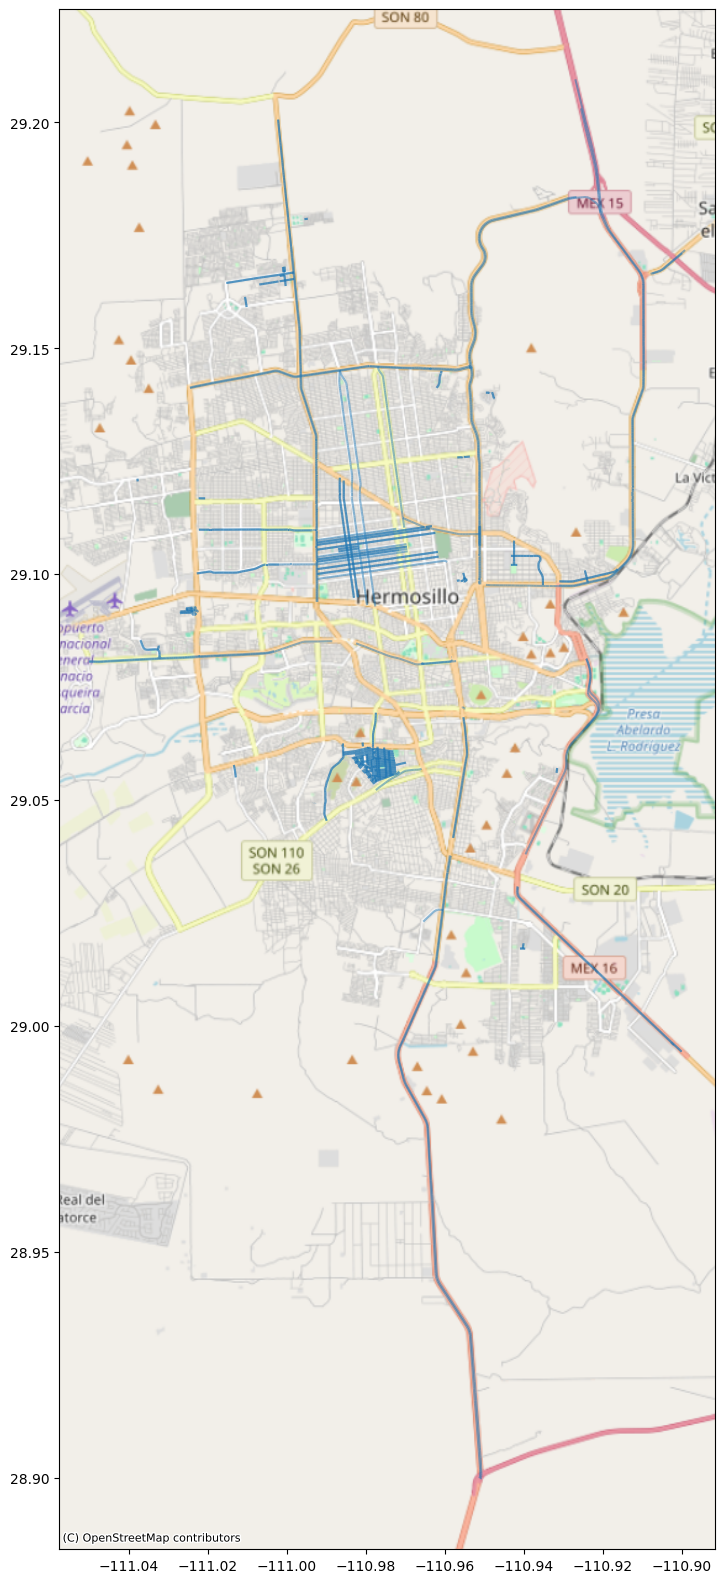

In [104]:
fig, ax = plt.subplots(1, figsize=(20, 20))
vialidades_urb[~vialidades_urb['maxspeed'].isnull()].plot(
    ax=ax,
    alpha=0.5,
    legend=True, 
)
add_basemap_to_ax(ax, vialidades_urb.crs)
plt.show()

In [105]:
vialidades_urb[~vialidades_urb['maxspeed'].isnull()]['nombre'].value_counts()

nombre
boulevard solidaridad                 477
boulevard josé maría morelos norte    320
boulevard enrique mazón lópez         298
boulevard progreso                    284
boulevard gustavo mazón lópez         222
                                     ... 
retorno de la morena                    4
avenida xolotl                          2
retorno pino americano                  2
bacum                                   2
cruceiros                               2
Name: count, Length: 129, dtype: int64

Las vialidades con dato de velocidad máxima son algunas de las vialiades más importantes de Hermosillo. 

Este dato es importante para el proposito del proyecto, por lo que aunque no tenga mucha presencia no lo eliminaremos. 

In [115]:
vialidades_urb.rename(columns={'maxspeed': 'vel_max'}, inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\1264173017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.rename(columns={'maxspeed': 'vel_max'}, inplace=True)


La cantidad de carriles es almacenado en la columna `lanes`:

In [106]:
vialidades_urb['lanes'].unique()

array([None, '2', '3', '4', '2;3', '1', '5', '6'], dtype=object)

In [108]:
vialidades_urb['lanes'].isnull().value_counts(normalize=True)

lanes
True     0.944059
False    0.055941
Name: proportion, dtype: float64

El 95% de los registros no poseen dato de cantidad de carriles. 

In [109]:
vialidades_urb['lanes'].value_counts()

lanes
2      3536
3      2208
4      1181
1       719
5       477
2;3      48
6        41
Name: count, dtype: int64

Analicemos su presencia en el mapa:

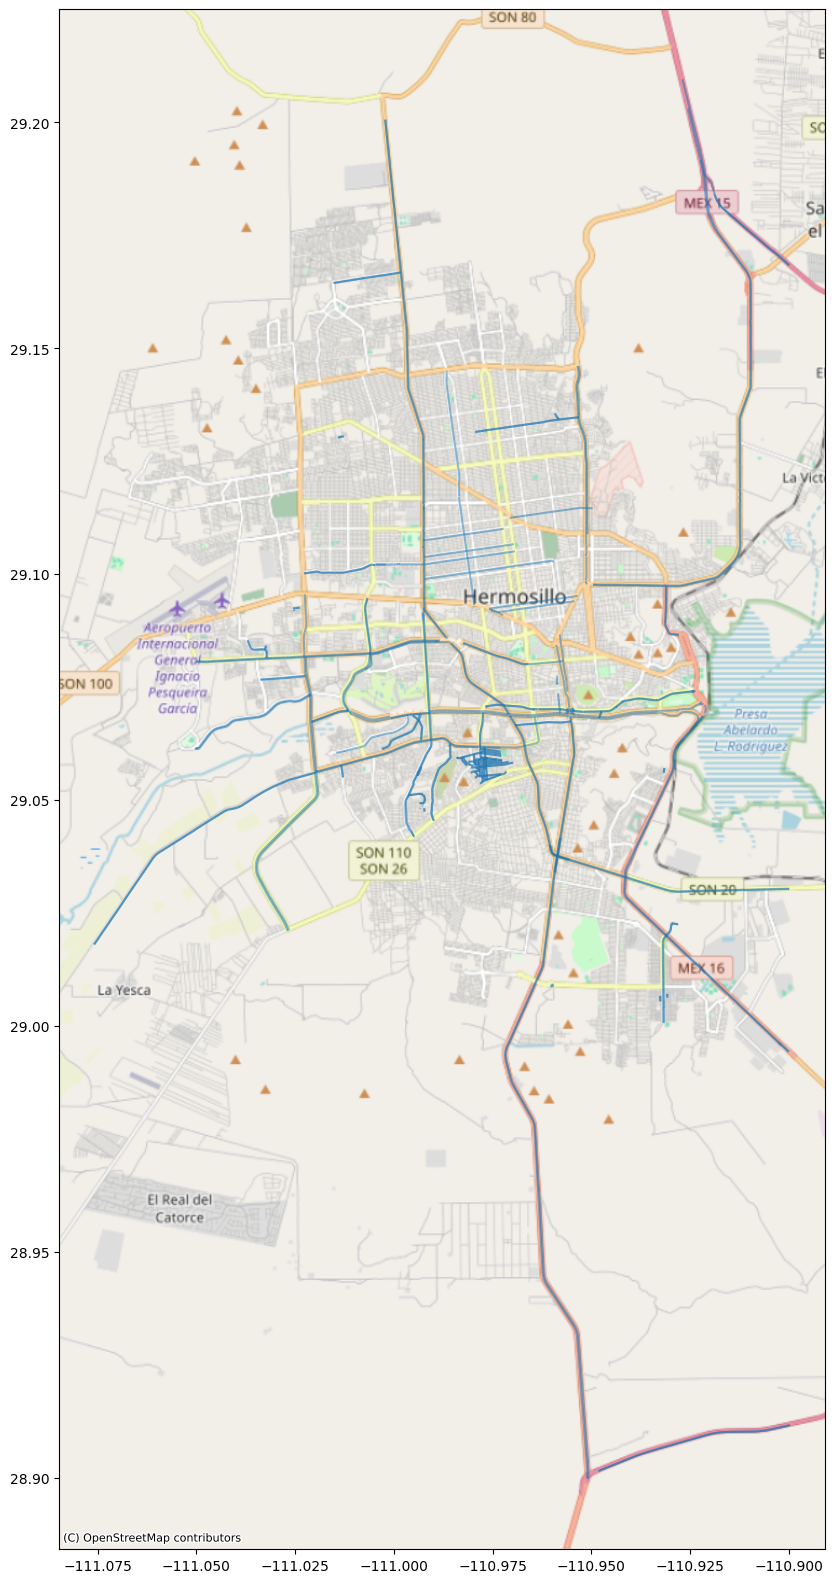

In [110]:
fig, ax = plt.subplots(1, figsize=(20, 20))
vialidades_urb[~vialidades_urb['lanes'].isnull()].plot(
    ax=ax,
    alpha=0.5,
    legend=True, 
)
add_basemap_to_ax(ax, vialidades_urb.crs)
plt.show()

In [111]:
vialidades_urb[~vialidades_urb['maxspeed'].isnull()]['nombre'].value_counts()

nombre
boulevard solidaridad                 477
boulevard josé maría morelos norte    320
boulevard enrique mazón lópez         298
boulevard progreso                    284
boulevard gustavo mazón lópez         222
                                     ... 
retorno de la morena                    4
avenida xolotl                          2
retorno pino americano                  2
bacum                                   2
cruceiros                               2
Name: count, Length: 129, dtype: int64

Las vialidades con dato de cantidad de carriles son algunas de las vialiades más importantes de Hermosillo. 

Este dato es importante para el proposito del proyecto, por lo que aunque no tenga mucha presencia no lo eliminaremos. 

In [114]:
vialidades_urb.rename(columns={'lanes': 'num_carriles'}, inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\3394025004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.rename(columns={'lanes': 'num_carriles'}, inplace=True)


El ancho (en metros) de la vialidad es almacenado por la columna `width`: 

In [136]:
vialidades_urb['width'].info()

<class 'pandas.core.series.Series'>
Index: 146763 entries, 55964 to 249876
Series name: width
Non-Null Count  Dtype 
--------------  ----- 
290 non-null    object
dtypes: object(1)
memory usage: 6.3+ MB


In [135]:
vialidades_urb['width'].describe()

count     290
unique      2
top         7
freq      182
Name: width, dtype: object

In [137]:
vialidades_urb['width'].unique()

array([None, '8', '7'], dtype=object)

Verifiquemos cuales vialidades son las que poseen datos: 

In [142]:
vialidades_urb[~vialidades_urb['width'].isnull()]['nombre'].unique()

array(['avenida ley 57', None, 'avenida constitución', 'llaneros',
       'san blas', 'santo tomás', 'los molinos', 'san melesio'],
      dtype=object)

Dado que son muy pocos datos y no influye de gran forma en al proposito del proyecto, podemos eliminar la columna `width`. 

In [144]:
vialidades_urb.drop(columns='width', inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\1167233295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.drop(columns='width', inplace=True)


El tipo de interesección: 

In [120]:
vialidades_urb['junction'].isnull().value_counts(normalize=True)

junction
True     0.994549
False    0.005451
Name: proportion, dtype: float64

In [119]:
vialidades_urb['junction'].unique()

array([None, 'roundabout'], dtype=object)

Menos del 1% de los datos posee valores. Además la información de tipo de intersección no es de utilidad para el proyecto, por lo que podemos eliminar esta columna. 

In [122]:
vialidades_urb.drop(columns='junction', inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\108008236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.drop(columns='junction', inplace=True)


La columna 'access' indica las restricciones de acceso a la vialidad: 

In [123]:
vialidades_urb['access'].unique()

array([None, 'yes'], dtype=object)

In [127]:
vialidades_urb['access'].value_counts()

access
yes    118
Name: count, dtype: int64

Solo 118 registros son de acceso reestringido.

La columna `access` no es de interes para el proyecto, podemos eliminarla: 

In [130]:
vialidades_urb.drop(columns='access', inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_10164\2961217442.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vialidades_urb.drop(columns='access', inplace=True)


Guardamos los datos en el directorio temporal: 

In [153]:
vialidades_urb.to_file(temp_dir.joinpath("vialidades_urb_clean.geojson"), driver='GeoJSON')

## 3. Conclusiones

El conunto de datos limpio posee la siguiente estructura: 

In [145]:
vialidades_urb.head()

tipo_vialidad                  nombre  un_sentido   longitud  \
55964   Calle residencial  enrique garcia sanchez       False  73.582388   
55965   Calle residencial  enrique garcia sanchez       False   9.545436   
55966        Vía primaria    abelardo l rodriguez        True  43.415225   
55967      Vía secundaria                    None        True  13.296867   
55968  Conector carretera      calle de los pinos        True  24.967452   

      vel_max num_carriles                                           geometry  
55964    None         None  LINESTRING (-110.95543 29.09141, -110.95535 29...  
55965    None         None  LINESTRING (-110.95543 29.09141, -110.95549 29...  
55966    None         None  LINESTRING (-110.95543 29.09141, -110.95523 29...  
55967    None            2  LINESTRING (-110.92364 29.0742, -110.92377 29....  
55968    None         None  LINESTRING (-110.92364 29.0742, -110.92389 29....

Se han conservado únicamente tramos correspondientes a la zona urbana de Hermosillo y los atributos necesarios para el análisis de accidentes y su relación con los baches. 

De las **18 columnas inicales**, se selccionarion **7 variables clave** que concentran la información reelevante para el análisis posterior: tipo y nombre de la vialidad, sentido, longitud, velocidad máxima, número de carriles y geometría. 

El proceso de limpieza descrito en esta libreta ha sido **automatizado** en el *script* [`src/clean_vialidades.py`](../src/clean_vialidades.py), asegurando reproducibilidad e integración al *pipeline* del proyecto. 